In [0]:
!unzip train.zip
!pip install -U scikit-learn

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

Read the grayscale images from the train directory.
The label of an image is given by the name of the subdirectory in which it can be found.

Note: Please make sure that the working directory contains the train directory of the dataset, before running this.


In [0]:
trainDir='./train'
directories = os.listdir(trainDir)
image_height=200
image_width=200
count = 0;
for i in range(len(directories)):
    for file in os.listdir(trainDir+'/'+directories[i]):
        count+=1
x_train = np.empty(shape=(count,image_height,image_width),)
y_train = np.zeros(count,dtype='int32')
count = 0
label = 0
y_originalNames = {}
for i in range(len(directories)):
    for file in os.listdir(trainDir+'/'+directories[i]):
        image = cv2.imread(trainDir+'/'+directories[i]+'/'+file,0)
        x_train[count] = image
        y_train[count] = label
        y_originalNames[label] = directories[i]
        count+=1
    label+=1
        

Lets plot an image from the dataset.


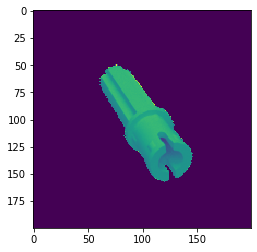

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

Since images with the same label are stored successively in the input(x_train), they need to be shuffled.So, a vector with all the possible indexes is created and shuffled and then it will be used to shuffle the input.

In [3]:
shuffle = np.arange(x_train.shape[0])
np.random.shuffle(shuffle)
print(shuffle)

[5596 5284 3687 ... 5911 5368 5618]


Here we normalize the pixels from images by dividing them with 255 and extracting the overall mean of the entire dataset.

In [0]:
x_train = x_train/255.0
train_mean = np.mean(x_train,axis=0) 
x_train-=train_mean

In [5]:
x_train=x_train[shuffle]
y_train = y_train[shuffle]
x_train = x_train.reshape(x_train.shape[0],200,200,1)
import gc
gc.collect()

0

This callback will be used to store the models after each epoch, in order to evaluate in the end the best one

In [0]:
import os
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)


In [0]:
## this function will be used later to plot the results of the models trainings
def plot(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Accuracies evolution')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss evolution')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()

Splitting the data in test and train data.


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2)

We start from a model of this structure:
```
Layer (type)                 Output Shape              Param #   

conv2d_58 (Conv2D)           multiple                  320       
_________________________________________________________________
conv2d_59 (Conv2D)           multiple                  9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_60 (Conv2D)           multiple                  18496     
_________________________________________________________________
conv2d_61 (Conv2D)           multiple                  36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_62 (Conv2D)           multiple                  73856     
_________________________________________________________________
conv2d_63 (Conv2D)           multiple                  147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_7 (Flatten)          multiple                  0         
_________________________________________________________________
dropout_25 (Dropout)         multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  1280016   

# This is formatted as code
```



In [0]:
model1 = tf.keras.models.Sequential([
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'), 
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(16, activation='softmax')
])

In [0]:
train_labels_oneHot =keras.utils.to_categorical(Y_train, num_classes=16, dtype='float32')
 
optimizer = Adam(lr=0.001)  

model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history1 = model1.fit(X_train[:-500], train_labels_oneHot[:-500],
          epochs=20, batch_size=128, initial_epoch=0,
          validation_data=(X_train[-500:], train_labels_oneHot[-500:]))

Train on 4603 samples, validate on 500 samples
Epoch 1/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 1.2595 - acc: 0.5655 - val_loss: 0.7267 - val_acc: 0.7280
Epoch 2/20
4603/4603 [==============================] - 8s 2ms/sample - loss: 0.5060 - acc: 0.8208 - val_loss: 0.5395 - val_acc: 0.7860
Epoch 3/20
4603/4603 [==============================] - 9s 2ms/sample - loss: 0.3905 - acc: 0.8507 - val_loss: 0.4658 - val_acc: 0.8180
Epoch 4/20
4603/4603 [==============================] - 9s 2ms/sample - loss: 0.2914 - acc: 0.8879 - val_loss: 0.3708 - val_acc: 0.8540
Epoch 5/20
4603/4603 [==============================] - 9s 2ms/sample - loss: 0.2269 - acc: 0.9120 - val_loss: 0.3819 - val_acc: 0.8500
Epoch 6/20
4603/4603 [==============================] - 8s 2ms/sample - loss: 0.1891 - acc: 0.9300 - val_loss: 0.3672 - val_acc: 0.8660
Epoch 7/20
4603/4603 [==============================] - 8s 2ms/sample - loss: 0.1482 - acc: 0.9444 - val_loss: 0.3147 - val_acc: 0.8840


Lets plot the evolution of accuracies and  loss values on train data and validation

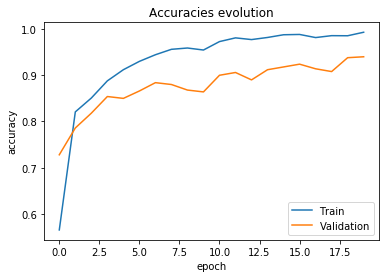

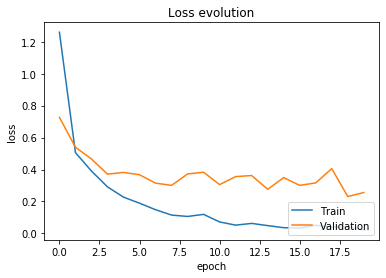

In [50]:
plot(history1)

In [52]:
test_labels = keras.utils.to_categorical(Y_test, num_classes=16, dtype='float32')
results = model1.evaluate(X_test, test_labels, verbose=0)
print('Loss and accuracy on the test data for the first model:',results)

Loss and accuracy on the test data: [0.26468326981094753, 0.94043887]


Trying to improve the above model by adding some convolution layers + some dropout  layers in order to avoid overfitting

In [0]:

model2 = tf.keras.models.Sequential([
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Dropout(0.2),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(16, activation='softmax')
])

In [54]:
optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(X_train[:-500], Y_train[:-500],
          epochs=20, batch_size=64, initial_epoch=0,
          validation_data=(X_train[-500:], Y_train[-500:]),callbacks = [checkpoint_callback])

Train on 4603 samples, validate on 500 samples
Epoch 1/20
4603/4603 [==============================] - 15s 3ms/sample - loss: 1.3339 - acc: 0.5247 - val_loss: 0.7611 - val_acc: 0.7240
Epoch 2/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 0.6101 - acc: 0.7830 - val_loss: 0.5633 - val_acc: 0.7660
Epoch 3/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 0.4278 - acc: 0.8414 - val_loss: 0.4710 - val_acc: 0.8240
Epoch 4/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 0.3416 - acc: 0.8723 - val_loss: 0.3931 - val_acc: 0.8440
Epoch 5/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 0.2908 - acc: 0.8927 - val_loss: 0.3121 - val_acc: 0.8460
Epoch 6/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 0.2260 - acc: 0.9179 - val_loss: 0.3678 - val_acc: 0.8680
Epoch 7/20
4603/4603 [==============================] - 10s 2ms/sample - loss: 0.2242 - acc: 0.9153 - val_loss: 0.3046 - val_acc: 0

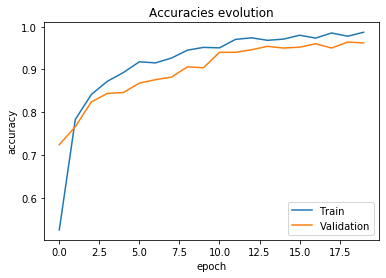

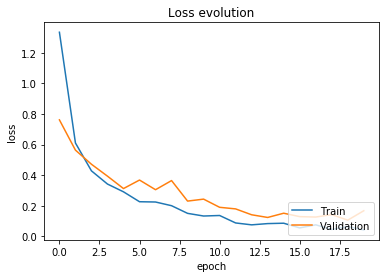

In [55]:
plot(history2)

In [56]:
results = model2.evaluate(X_test, Y_test, verbose=0)
print('Loss and accuracy on the test data for the second model:', results)

Loss and accuracy on the test data for the second model: [0.17031793845204352, 0.95846397]


What accuracy we get on test data with the best model

In [61]:
from tensorflow.keras.models import load_model
  
best_epoch = 19
best_model = load_model('./checkpoints/model.%05d.hdf5' % best_epoch)
predicted_test_labels_scores = best_model.predict(X_test)
predicted_test_labels = np.argmax(predicted_test_labels_scores, axis=-1)
accuracy = np.mean(predicted_test_labels == Y_test)
print('Accuracy obtained on the test data with the best model( according to the results obtained on the validation data)\n', accuracy)
matrix = confusion_matrix(predicted_test_labels, Y_test)
print('Confusion matrix on the test data:\n',matrix)

Accuracy obtained on the test data with the best model( according to the results obtained on the validation data)
 0.9647335423197492
Confusion matrix on the test data:
 [[86  0  0  0  0  0  2  0  4  0  0  0  0  0  0  0]
 [ 0 77  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 2  0 84  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 84  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 62  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1 74  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0 80  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 69  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 70  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  0 82  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  2  0  2  0 90  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 95  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0 75  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 68  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0 78  0]
 [ 1  0  0  1  0  0  0  0  0  0  0  0  0  7  0 57]]


Check if adding more layers improves the accuracy even more or not.

In [0]:

model3 = tf.keras.models.Sequential([
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'), 
  layers.Dropout(0.2),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Dropout(0.2),
  layers.Conv2D(filters=128, kernel_size=5, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=128, kernel_size=5, activation='relu', strides=1, padding='same'),
  layers.Dropout(0.2),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, padding='same'),
  layers.MaxPool2D(pool_size=2, strides=(2,2), padding='same'),
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(16, activation='softmax')
])

In [73]:
optimizer = Adam(lr=0.001)
model3.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(X_train[:-500], Y_train[:-500],
          epochs=20, batch_size=64, initial_epoch=0,
          validation_data=(X_train[-500:], Y_train[-500:]),
           callbacks = [checkpoint_callback])

Train on 4603 samples, validate on 500 samples
Epoch 1/20
4603/4603 [==============================] - 23s 5ms/sample - loss: 1.8425 - acc: 0.4197 - val_loss: 6.2258 - val_acc: 0.0500
Epoch 2/20
4603/4603 [==============================] - 11s 2ms/sample - loss: 0.9448 - acc: 0.6585 - val_loss: 6.8309 - val_acc: 0.0260
Epoch 3/20
4603/4603 [==============================] - 11s 2ms/sample - loss: 0.7343 - acc: 0.7300 - val_loss: 7.7093 - val_acc: 0.0580
Epoch 4/20
4603/4603 [==============================] - 11s 2ms/sample - loss: 0.6240 - acc: 0.7675 - val_loss: 9.6431 - val_acc: 0.0620
Epoch 5/20
4603/4603 [==============================] - 11s 2ms/sample - loss: 0.4713 - acc: 0.8229 - val_loss: 9.6503 - val_acc: 0.0820
Epoch 6/20
4603/4603 [==============================] - 11s 2ms/sample - loss: 0.4206 - acc: 0.8412 - val_loss: 4.5685 - val_acc: 0.2580
Epoch 7/20
4603/4603 [==============================] - 11s 2ms/sample - loss: 0.3516 - acc: 0.8712 - val_loss: 0.9898 - val_acc: 0

As it can be seen bellow the accuracy is not better than the one obtained with model2.

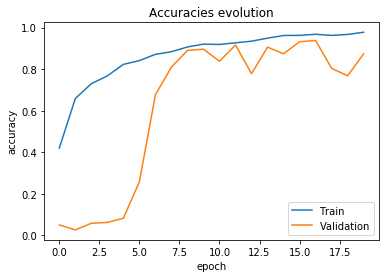

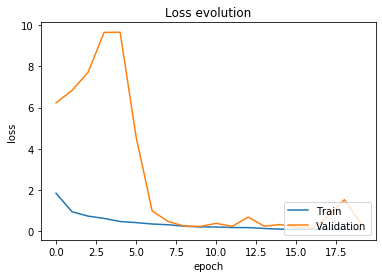

In [75]:
plot(history3)

In [76]:
results = model3.evaluate(X_test, Y_test, verbose=0)
print('Loss and accuracy on the test data for the second model:',results)

Loss and accuracy on the test data for the second model: [0.3838028149171309, 0.90125394]


In [28]:
results = model4.evaluate(X_test, Y_test, verbose=0)
print('Loss and accuracy on the test data for the 4th model:', results)

Loss and accuracy on the test data for the 4th model: [0.2412025715022999, 0.911442]
